# NVD CVE Analysis Status Stats
---

## Code & Data Setup

In [1]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import glob
import json
import logging
import calplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import warnings
from datetime import datetime

logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")


In [2]:
row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                modified_date = entry['cve']['lastModified']
            except KeyError:
                modified_date = 'Missing_Data'
            try:
                vuln_status = entry['cve']['vulnStatus']
            except KeyError:
                vuln_status = 'Missing_Data'
           
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'Modified': modified_date,
                "VulnStatus" : vuln_status
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Modified'] = pd.to_datetime(nvd['Modified'])
thisyear = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2026-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2024, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

nvd_vulnstats = nvd['VulnStatus'].value_counts()
nvd_vulnstats = nvd_vulnstats.reset_index()
nvd215 = nvd.copy()

sincenotice = ((nvd['Published'] > '2024-02-15') & (nvd['Published']  < '2026-01-01'))
nvd215 = nvd.loc[sincenotice]
nvd215_vulnstats = nvd215['VulnStatus'].value_counts()
nvd215_vulnstats = nvd215_vulnstats.reset_index()
nvd215_awaiting_analysis = nvd215[nvd215['VulnStatus']=='Awaiting Analysis']
nvd215_awaiting_analysis = nvd215_awaiting_analysis[['CVE']]

nvd_Analyzed = nvd.copy()
nvd_Analyzed = nvd_Analyzed[nvd_Analyzed['VulnStatus']=='Analyzed']
nvd_Analyzed = nvd_Analyzed.sort_values(by="Modified", ascending=False)
pnvd215 = nvd.copy()
pnvd215_analyzed = pnvd215[pnvd215['VulnStatus']=='Analyzed']
nvd215count = nvd215['Published'].count()
startdate = date(2024, 2, 15)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day_p = nvd215count/numberofdays.days

nvd215Acount = pnvd215_analyzed['Published'].count()
startdate = date(2024, 2, 15)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day_a = nvd215Acount/numberofdays.days
nvd_awaiting_analyzed = nvd[nvd['VulnStatus']=='Awaiting Analysis']
days_to_analyze = len(nvd_awaiting_analyzed)/55

now = datetime.now()
def suffix(day):
  suffix = ""
  if 4 <= day <= 20 or 24 <= day <= 30:
    suffix = "th"
  else:
    suffix = ["st", "nd", "rd"][day % 10 - 1]
  return suffix
report_date = now.strftime("%b %-d" + suffix(now.day))

## NVD CVE Analysis Stats Status

In [3]:
print("### NVD Analysis Update for", report_date)
print("-", nvd['CVE'].count() , "CVEs published since 2024-02-15.")
print("-", len(nvd_awaiting_analyzed) , "CVEs published since 2024-02-15 have not been analyzed.")
print("- NVD has analyzed" , nvd215_vulnstats.at[1, "count"] , "CVEs published since February 15th, 2024.")
print("- For the" , len(nvd_awaiting_analyzed) , "unanalyzed CVEs. Analyzing the pre-Feb 15th 2024 average, emptying the backlog would take" , round(days_to_analyze)  , "days.")



### NVD Analysis Update for Jul 15th
- 67224 CVEs published since 2024-02-15.
- 25318 CVEs published since 2024-02-15 have not been analyzed.
- NVD has analyzed 25297 CVEs published since February 15th, 2024.
- For the 25318 unanalyzed CVEs. Analyzing the pre-Feb 15th 2024 average, emptying the backlog would take 460 days.


### Calendar View

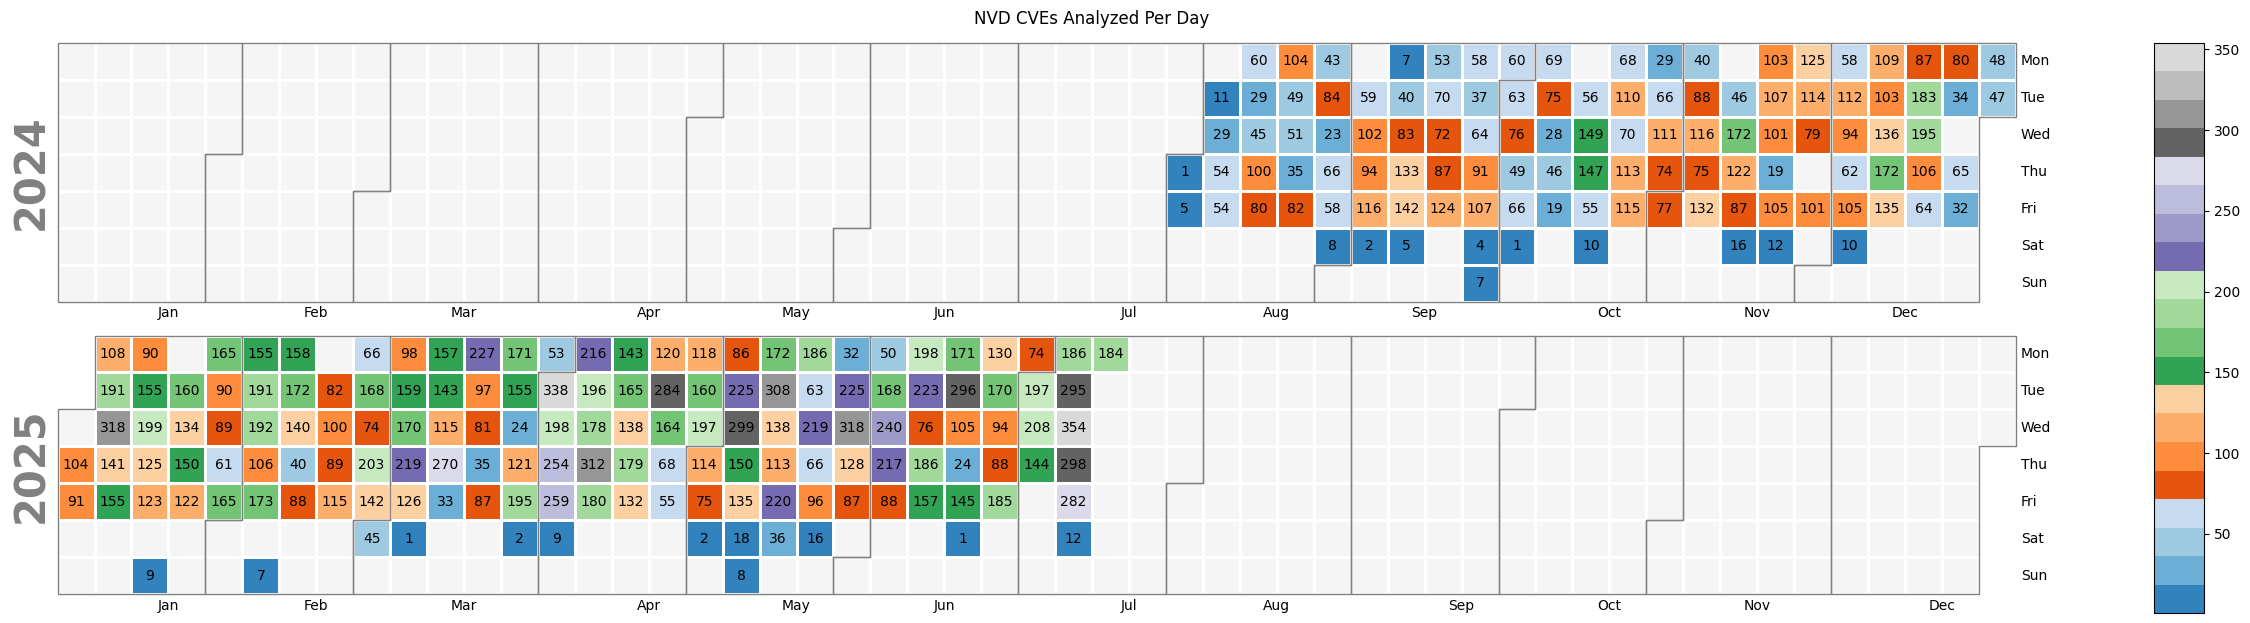

In [4]:
nvd_Analyzed = nvd.copy()
nvd_Analyzed = nvd_Analyzed[nvd_Analyzed['VulnStatus']=='Analyzed']
nvd_Analyzed = nvd_Analyzed.sort_values(by="Modified", ascending=False)
dfs = nvd_Analyzed['Modified'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
average_value = df.T.squeeze().mean()
calplot.calplot(df.T.squeeze(), cmap='tab20c', dropzero=True, edgecolor="Grey", textcolor="black", textformat='{:.0f}', textfiller='', suptitle='NVD CVEs Analyzed Per Day', figsize=(25,6));

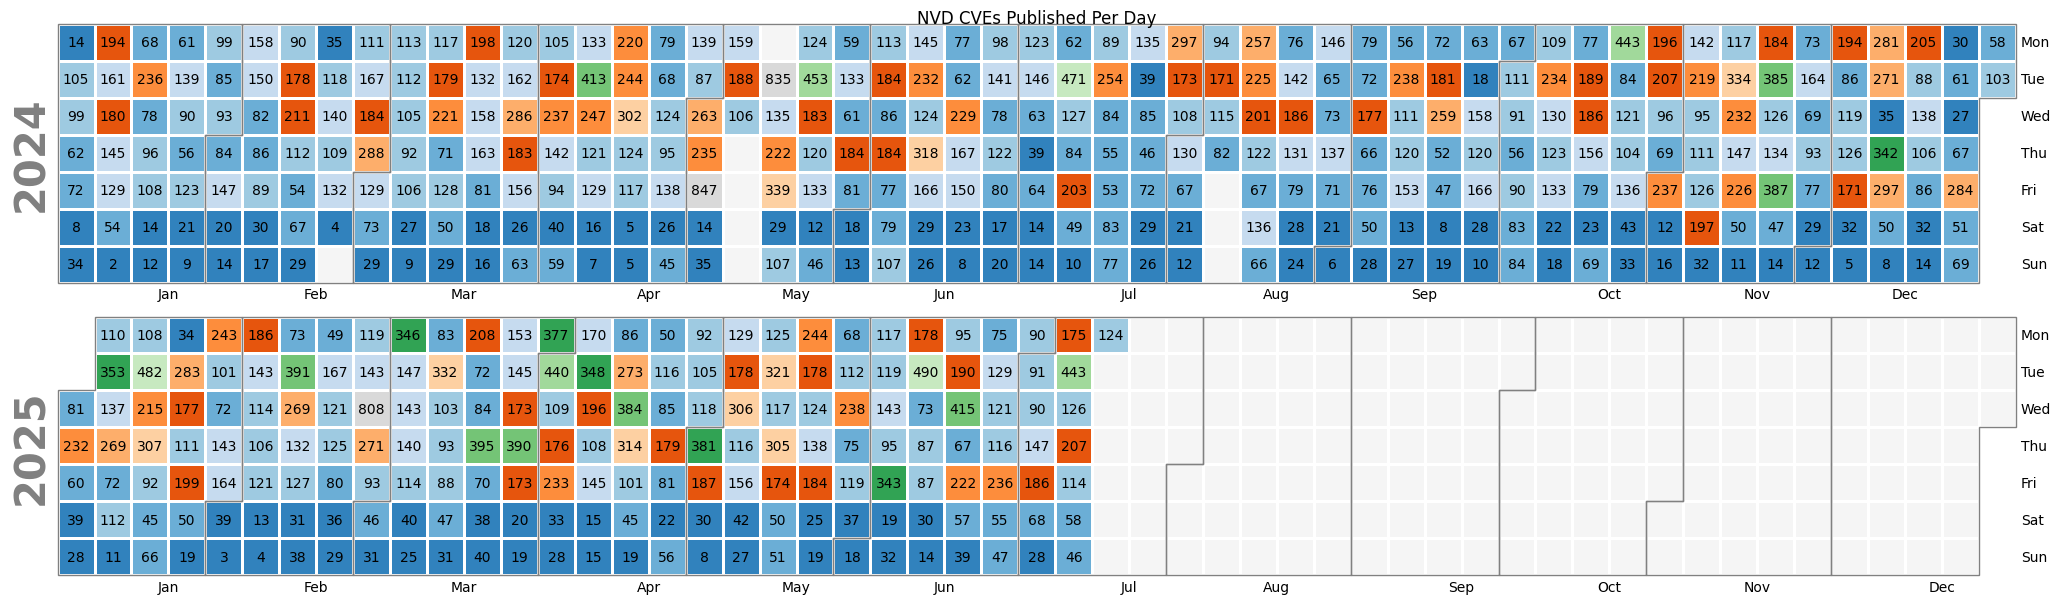

In [5]:
dfs = nvd['Published'].apply(lambda x: pd.to_datetime(x, errors='coerce', format='%Y/%m/%d'))
df = dfs.value_counts()
df = df.to_frame()
df.index = df.index.strftime('%m/%d/%Y')
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
average_value = df.T.squeeze().mean()
calplot.calplot(df.T.squeeze(), cmap='tab20c', dropzero=True, edgecolor="Grey", textcolor="black", textformat='{:.0f}', textfiller='', suptitle='NVD CVEs Published Per Day', figsize=(25,6));

### Combined 2024-2025 CVE Status Stats

In [6]:
nvd_vulnstats 

,VulnStatus,count
0,Analyzed,29261
1,Awaiting Analysis,25318
2,Modified,10056
3,Rejected,1782
4,Received,421
5,Undergoing Analysis,386


### Post Feb 15th 2024 CVE Status Stats

In [7]:
nvd215_vulnstats 

,VulnStatus,count
0,Analyzed,29170
1,Awaiting Analysis,25297
2,Modified,6271
3,Rejected,1679
4,Received,421
5,Undergoing Analysis,383
